In [1]:
import pandas as pd

def read_from_csv(file_path):
    # 헤더 두 줄 읽기
    headers = pd.read_csv(file_path, skiprows=11, nrows=2, header=None).T
    upper = headers[0].ffill().tolist()
    lower = headers[1].tolist()

    # 컬럼명 생성
    combined_columns = [
        f"{str(u).strip()} {str(l).strip()}" if pd.notna(u) and pd.notna(l)
        else str(l).strip() or str(u).strip()
        for u, l in zip(upper, lower)
    ]

    # 본문 데이터 읽기
    df = pd.read_csv(file_path, skiprows=13, header=None)

    # 컬럼 수 맞추기
    min_len = min(len(combined_columns), df.shape[1])
    df = df.iloc[:, :min_len]
    df.columns = combined_columns[:min_len]

    # 전부 0인 컬럼 제거 + 중복 컬럼 제거
    df = df.loc[:, ~((df.fillna(0) == 0).all())]
    df = df.loc[:, ~df.columns.duplicated()]

    # KPI 키워드 필터링
    kpis = ["kbps", "MCS", "Wideband CQI", "RI", "PDU"]
    df = df.loc[:, [col for col in df.columns if any(k in col for k in kpis)]]

    # CodeWord0+1 포함된 것만 필터링
    df = df.loc[:, [col for col in df.columns if "CodeWord0+1" in col]]
    df.columns = df.columns.str.replace("CodeWord0\\+1", "", regex=True).str.strip()

    # 시간 컬럼 생성
    df = df.reset_index().rename(columns={"index": "Time[sec]"})
    
    return df

def read_from_xlsx(file_path):
    df_raw = pd.read_excel(file_path, sheet_name="Sheet1")
    df_cut = df_raw.filter(regex="^(TIME_STAMP|LTE KPI PCell )")
    df_cut.columns = [
        col if col == "TIME_STAMP" else col.replace("LTE KPI PCell ", "")
        for col in df_cut.columns
    ]

    df_cut = df_cut[df_cut["Serving PCI"] == 1].reset_index(drop=True)
    df_cut = df_cut[df_cut["Serving EARFCN(DL)"].isin([9560, 8790])].reset_index(drop=True)
    df_cut = df_cut[df_cut["Serving Band"].isin(["Band 28", "Band 26"])].reset_index(drop=True)

    col_rsrp = "Serving RSRP [dBm]"
    rsrp0 = df_cut[col_rsrp].iloc[0]
    for i, rsrp in enumerate(df_cut[col_rsrp]):
        if abs(rsrp - rsrp0) > 0.5:
            df_cut = df_cut.iloc[i:].reset_index(drop=True)
            break

    df_kpi = df_cut.reset_index().rename(columns={"index": "Time[sec]"})
    
    return df_kpi

In [2]:
df_xlsx = read_from_xlsx("250722-Zflip7-LSI-E2500-wireless/clean.xlsx")
df_xlsx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Time[sec]                      327 non-null    int64         
 1   TIME_STAMP                     327 non-null    datetime64[ns]
 2   Serving PCI                    327 non-null    int64         
 3   Serving Band                   327 non-null    object        
 4   Serving EARFCN(DL)             327 non-null    int64         
 5   Serving EARFCN(UL)             327 non-null    int64         
 6   Serving BandWidth(DL)          327 non-null    int64         
 7   Serving BandWidth(UL)          327 non-null    int64         
 8   Serving RSRP [dBm]             327 non-null    int64         
 9   Serving RSRQ [dB]              327 non-null    int64         
 10  Serving RSSI [dBm]             327 non-null    int64         
 11  PUSCH Power [dBm]  

In [3]:
df_csv = read_from_csv("250722-Zflip7-LSI-E2500-wireless/clean.csv")
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Time[sec]                    569 non-null    int64  
 1   Tx MAC PDU [PDUs]            569 non-null    int64  
 2   Tx Retrans MAC PDU [PDUs]    569 non-null    int64  
 3   Tx Discarded MAC PDU [PDUs]  569 non-null    int64  
 4   Tx Rate [kbps]               569 non-null    float64
 5   Tx Throughput [kbps]         569 non-null    float64
 6   MCS#0                        569 non-null    int64  
 7   MCS#1                        569 non-null    int64  
 8   MCS#3                        569 non-null    int64  
 9   MCS#6                        569 non-null    int64  
 10  MCS#8                        569 non-null    int64  
 11  MCS#10                       569 non-null    int64  
 12  MCS#12                       569 non-null    int64  
 13  MCS#14              

In [4]:
# df_csv.iloc[:,6:24]
# df_csv.iloc[:,24:40]
# df_csv.iloc[:,40:42]

In [5]:
def weighted_avg(df, prefix):
    cols = [col for col in df.columns if col.startswith(prefix)]
    return df[cols].apply(
        lambda row: (
            sum(int(col.split('#')[1]) * row[col] for col in row.index if row[col] > 0) /
            sum(row[col] for col in row.index if row[col] > 0)
        ) if sum(row[col] for col in row.index if row[col] > 0) > 0 else pd.NA,
        axis=1
    )
    
def kpis_from_csv(file_path, out_start, interval):
    df = read_from_csv(file_path)

    # MCS, CQI, RI 가중 평균
    df["MCS_avg"] = weighted_avg(df, "MCS#")
    df["CQI_avg"] = weighted_avg(df, "Wideband CQI#")
    df["RI_avg"]  = weighted_avg(df, "RI#")

    # BLER 계산
    total = df["Tx MAC PDU [PDUs]"]
    retrans = df["Tx Retrans MAC PDU [PDUs]"]
    discard = df["Tx Discarded MAC PDU [PDUs]"]
    df["BLER"] = ((retrans + discard) / total.replace(0, pd.NA)) * 100

    # '#숫자' 포함 컬럼 제거
    df = df.loc[:, ~df.columns.str.contains(r'#\d+')].copy()

    # 'PDU' 포함된 컬럼도 제거
    df = df.loc[:, ~df.columns.str.contains("PDU", case=False, na=False)]

    # 단위 변환 (kbps → Mbps)
    df.loc[:, "Tx Rate [kbps]"] = df["Tx Rate [kbps]"] / 1000
    df.loc[:, "Tx Throughput [kbps]"] = df["Tx Throughput [kbps]"] / 1000

    # 컬럼명 리네임
    rename_dict = {
        "Tx Rate [kbps]": "DL_PHY_Tput[Mbps]",
        "Tx Throughput [kbps]": "DL_MAC_Tput[Mbps]",
        "MCS_avg": "DL_MCS",
        "CQI_avg": "CQI",
        "RI_avg": "RI",
        "BLER":"DL_BLER[%]",
    }
    df = df.rename(columns=rename_dict)

    num_rows = len(df)
    out_values = [out_start - i for i in range(num_rows // interval + 1)]
    out_series = [v for v in out_values for _ in range(interval)][:num_rows]
    df["Output_Power[dBm]"] = out_series

    # DL MAC Tput이 0이 되는 시점까지 자르기
    cutoff_idx = df[df["DL_MAC_Tput[Mbps]"] == 0].index.min()
    if pd.notna(cutoff_idx):
        df = df.loc[:cutoff_idx]

    df.reset_index(drop=True, inplace=True)
    df = df.round(2)

    cols = df.columns.tolist()
    first_cols = ["Time[sec]", "Output_Power[dBm]"]
    rest_cols = [col for col in cols if col not in first_cols]
    df = df[first_cols + rest_cols]
    
    return df

def kpis_from_xlsx(file_path, out_start, interval):
    df = read_from_xlsx(file_path)
    rename_dict = {
        "Time[sec]":"Time[sec]",
        "Serving RSRP [dBm]": "RSRP[dBm]",
        "Serving RSRQ [dB]": "RSRQ[dB]",
        "Serving RSSI [dBm]": "RSSI[dBm]",
        "SINR [dB]": "SINR[dB]",
        # "PDSCH BLER [%]": "DL_BLER[%]",
        # "DL MCS0": "DL_MCS",
        # "PDSCH PRB Number(Including 0)": "DL_RB_Num",
        # "PDSCH Throughput [Mbps]": "DL_PHY_Tput[Mbps]",
        # "MAC DL Throughput [Mbps]": "DL_MAC_Tput[Mbps]",
        # "WB CQI CW0": "CQI",
        # "WB RI2 Rate": "RI2_Rate[%]",
    }

    columns_to_display = [col for col in rename_dict if col in df.columns]
    df_renamed = df[columns_to_display].rename(columns=rename_dict)
    df_renamed = df_renamed.reset_index(drop=True)

    final_columns = [
        'Time[sec]',
        'RSRP[dBm]', "RSRQ[dB]","RSSI[dBm]","SINR[dB]",
        # 'DL_PHY_Tput[Mbps]', "DL_MAC_Tput[Mbps]", 'DL_RB_Num','DL_BLER[%]',
        # 'DL_MCS', "CQI", 'RI2_Rate[%]'
    ]
    final_columns = [col for col in final_columns if col in df_renamed.columns]
    df_filtered = df_renamed[final_columns]
    df_filtered = df_filtered.fillna(0)

    num_rows = len(df_filtered)
    out_values = [out_start - i for i in range(num_rows // interval + 1)]
    out_series = [v for v in out_values for _ in range(interval)][:num_rows]
    df_filtered["Output_Power[dBm]"] = out_series

    cols = df_filtered.columns.tolist()
    first_cols = ["Time[sec]", "Output_Power[dBm]"]
    rest_cols = [col for col in cols if col not in first_cols]
    df_filtered = df_filtered[first_cols + rest_cols]

    return df_filtered

In [6]:
df_csv = kpis_from_csv("250722-Zflip7-LSI-E2500-wireless/clean.csv", out_start=-50, interval=10)
df_csv

,Time[sec],Output_Power[dBm],DL_PHY_Tput[Mbps],DL_MAC_Tput[Mbps],DL_MCS,CQI,RI,DL_BLER[%]
0,0,-50,195.79,195.79,27.00,15.0,2.0,0.0
1,1,-50,195.79,195.79,27.00,15.0,2.0,0.0
2,2,-50,195.79,195.79,27.00,15.0,2.0,0.0
3,3,-50,195.79,195.79,27.00,15.0,2.0,0.0
4,4,-50,195.79,195.79,27.00,15.0,2.0,0.0
...,...,...,...,...,...,...,...,...
413,413,-91,4.58,0.00,1.00,1.96,1.0,99.9
414,414,-91,4.58,0.01,1.00,1.96,1.0,99.7
415,415,-91,4.55,0.04,0.98,1.962,1.0,99.2
416,416,-91,4.54,0.00,0.98,1.96,1.0,99.9


In [7]:
df_xlsx = kpis_from_xlsx("250722-Zflip7-LSI-E2500-wireless/clean.xlsx", out_start=-50, interval=5)
df_xlsx

,Time[sec],Output_Power[dBm],RSRP[dBm],RSRQ[dB],RSSI[dBm],SINR[dB]
0,0,-50,-69,-8,-40,40.0
1,1,-50,-69,-8,-40,40.0
2,2,-50,-69,-8,-40,40.0
3,3,-50,-69,-8,-40,40.0
4,4,-50,-69,-8,-40,40.0
...,...,...,...,...,...,...
322,322,-114,-133,-18,-96,-6.0
323,323,-114,-133,-18,-96,-6.0
324,324,-114,-133,-18,-96,-6.0
325,325,-115,-133,-18,-96,-6.0


In [8]:
import os
import pandas as pd
def concat_kpi_common(dfs):
    df = pd.concat(dfs, ignore_index=True)
    clean_times = df[df["UHD_Power"] == "clean"]["Time[sec]"].unique()
    df = df[df["Time[sec]"].isin(clean_times)].copy()

    concat_col = "Out_Int"

    rsrp_clean = df[df["UHD_Power"] == "clean"][["Time[sec]", "Output_Power[dBm]"]]
    rsrp_clean = rsrp_clean.rename(columns={"Output_Power[dBm]": concat_col})
    df = df.merge(rsrp_clean, on="Time[sec]", how="left")


    df[concat_col] = df[concat_col].round().astype(int)
    drop_cols = [concat_col, 'UHD_Power']
    kpi_cols = [col for col in df.columns if col not in drop_cols]

    df_binning = df.groupby([concat_col, "UHD_Power"])[kpi_cols].mean().round(2)
    df_binning = df_binning.sort_index(level=concat_col, ascending=False)

    return df_binning

def concat_kpi_from_csv(test_dir, out_start, interval):
    directory_path = os.getcwd()
    input_path = os.path.join(directory_path, test_dir)

    # ✅ 대상 파일 수집
    csv_files = [
        f for f in os.listdir(input_path)
        if f.endswith(".csv") and '$' not in f and "kpis" not in f
    ]

    # ✅ KPI 누적
    dfs = []
    for filename in csv_files:
        file_path = os.path.join(input_path, filename)
        file_tag = os.path.splitext(filename)[0]
        try:
            df_kpi = kpis_from_csv(file_path, out_start, interval)
            df_kpi["UHD_Power"] = file_tag
            dfs.append(df_kpi)
        except Exception as e:
            print(f"❌ 처리 실패: {filename} → {e}")
    
    df =concat_kpi_common(dfs)
    # output_path = os.path.join(test_dir, f"{test_dir}_kpis_from_csv.xlsx")
    # df.to_excel(output_path, index=True, float_format="%.2f")
    return df

def concat_kpi_from_xlsx(test_dir, out_start, interval):
    directory_path = os.getcwd()
    input_path = os.path.join(directory_path, test_dir)

    # ✅ 대상 파일 수집
    excel_files = [
        f for f in os.listdir(input_path)
        if f.endswith(".xlsx") and '$' not in f and "kpis" not in f
    ]

    # ✅ KPI 누적
    dfs = []
    for filename in excel_files:
        file_path = os.path.join(input_path, filename)
        file_tag = os.path.splitext(filename)[0]
        try:
            df_kpi = kpis_from_xlsx(file_path, out_start, interval)
            df_kpi["UHD_Power"] = file_tag
            dfs.append(df_kpi)
        except Exception as e:
            print(f"❌ 처리 실패: {filename} → {e}")

    df =concat_kpi_common(dfs)
    # output_path = os.path.join(test_dir, f"{test_dir}_kpis_from_csv.xlsx")
    # df.to_excel(output_path, index=True, float_format="%.2f")
    return df

In [9]:
df = concat_kpi_from_csv("250722-Zflip7-LSI-E2500-wireless", out_start=-50, interval=10)
display(df)

Time[sec]  Output_Power[dBm]  DL_PHY_Tput[Mbps]  \
Out_Int UHD_Power                                                    
-50     clean            4.5              -50.0             195.73   
        2dBm             4.5              -50.0             195.65   
-51     clean           14.5              -51.0             195.70   
        2dBm            14.5              -51.0             195.70   
-52     clean           24.5              -52.0             195.65   
...                      ...                ...                ...   
-89     2dBm           394.5              -89.0               8.59   
-90     clean          404.5              -90.0               4.58   
        2dBm           404.5              -90.0               4.66   
-91     clean          413.5              -91.0               4.56   
        2dBm           413.5              -91.0               4.58   

                   DL_MAC_Tput[Mbps]  DL_MCS      CQI   RI  DL_BLER[%]  
Out_Int UHD_Power                                                       
-50     clean                 195.73   27.00  14.9978  2.0        0.00  
        2dBm                  195.65   26.99  14.9946  2.0        0.00  
-51     clean                 195.68   27.00  14.9966  2.0        0.01  
        2dBm                  195.70   27.00  14.9964  2.0        0.00  
-52     clean                 195.60   27.00  14.9946  2.0        0.02  
...                              ...     ...      ...  ...         ...  
-89     2dBm                    0.92    2.40   2.6744  1.0       89.14  
-90     clean                   0.12    1.00    1.994  1.0       97.39  
        2dBm                    0.20    1.03   2.0182  1.0       95.73  
-91     clean                   0.02    0.99  1.96625  1.0       99.48  
        2dBm                    0.06    1.00  2.00025  1.0       98.79  

[84 rows x 8 columns]

In [10]:
df = concat_kpi_from_xlsx("250722-Zflip7-LSI-E2500-wireless", out_start=-50, interval=5)
display(df)

Time[sec]  Output_Power[dBm]  RSRP[dBm]  RSRQ[dB]  \
Out_Int UHD_Power                                                      
-50     clean            2.0              -50.0      -69.0      -8.0   
        -35dBm           2.0              -50.0      -67.0      -7.0   
-51     clean            7.0              -51.0      -70.0      -8.0   
        -35dBm           7.0              -51.0      -68.0      -7.0   
-52     clean           12.0              -52.0      -71.0      -8.0   
...                      ...                ...        ...       ...   
-113    -35dBm         317.0             -113.0     -130.0     -19.2   
-114    clean          322.0             -114.0     -132.8     -17.8   
        -35dBm         322.0             -114.0     -131.2     -20.0   
-115    clean          325.5             -115.0     -133.5     -18.5   
        -35dBm         325.5             -115.0     -132.5     -21.0   

                   RSSI[dBm]  SINR[dB]  
Out_Int UHD_Power                       
-50     clean          -40.0      40.0  
        -35dBm         -40.0      40.0  
-51     clean          -41.0      40.0  
        -35dBm         -41.0      40.0  
-52     clean          -42.0      39.0  
...                      ...       ...  
-113    -35dBm         -95.0      -6.0  
-114    clean          -95.8      -5.8  
        -35dBm         -95.0      -7.0  
-115    clean          -96.0      -6.5  
        -35dBm         -95.0      -8.0  

[132 rows x 6 columns]

In [11]:
import matplotlib.pyplot as plt
import math
import numpy as np
import os
from matplotlib.ticker import MultipleLocator, FixedLocator

def plot_kpis(test_dir, out_start, interval, if_name="ATSC3.0 / 6MHz", file_format='csv', rsrp_class='all'):

    if file_format == 'csv':
        df_stacked = concat_kpi_from_csv(test_dir=test_dir, out_start=out_start, interval=interval)
    elif file_format == 'xlsx':
        df_stacked = concat_kpi_from_xlsx(test_dir=test_dir, out_start=out_start, interval=interval)
        
    df_stacked_reset = df_stacked.reset_index()
    # display(df_stacked_reset)
    
    out_start = df_stacked_reset["Out_Int"].max()
    out_end = df_stacked_reset["Out_Int"].min()
    out_low = out_start - (out_start-out_end)/2
    out_edge = out_low - (out_start-out_end)/4

    if rsrp_class == 'high':
        out_end = out_low
    elif rsrp_class == 'low':
        out_start = out_low
    elif rsrp_class == 'edge':
        out_start = out_edge

    df_filter = df_stacked_reset[(df_stacked_reset["Out_Int"] <= out_start) & (df_stacked_reset["Out_Int"] >= out_end)]
    start_tick = int(math.floor(out_start / 5.0)) * 5
    end_tick = int(math.ceil(out_end / 5.0)) * 5
    xtick_labels = list(range(start_tick, end_tick - 1, -5))

    unique_powers = df_filter["UHD_Power"].unique().tolist()
    sorted_powers = sorted(
        unique_powers,
        key=lambda x: -999 if x == "clean" else (
            999 if x == "n26_15M" else int(x.replace("dBm", "")) if "dBm" in x and x.replace("dBm", "").lstrip("-").isdigit() else 0
        )
    )
    source_order = {power: idx + 1 for idx, power in enumerate(sorted_powers)}

    style_map = {}
    cmap = plt.get_cmap("tab20b")    
    base_sources = [s for s in source_order if s not in ['clean', 'n26_15M']]
    num_base = len(base_sources)
    base_colors = [cmap(i / 20) for i in np.linspace(4, 19, num=num_base, dtype=int)]
    base_markers = ['s', 'D', '^', 'v', '<', '>', '*', 'P', 'X', '.', ',', '1', '2', '3', '4']
    
    style_map['clean'] = {'color': 'blue', 'linestyle': '-', 'linewidth': 1, 'marker': 'o'}      
    if 'n26_10M' in source_order:
        style_map['n26_10M'] = {'color': 'gray', 'linestyle': ':', 'linewidth': 2, 'marker': None}
  
    for i, s in enumerate(base_sources):
        style_map[s] = {
            'color': base_colors[i % len(base_colors)],
            'linestyle': '-',
            'linewidth': 1,
            'marker': base_markers[i % len(base_markers)]
        }
    
    def plot_kpi_group(kpi_dict, n_rows, n_cols, filename):
        subplot_width, subplot_height = 7, 6
        figsize = (n_cols * subplot_width, n_rows * subplot_height + 1)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        axs = axs.flatten()

        for i, (kpi, cfg) in enumerate(kpi_dict.items()):
            ax = axs[i]
            for j, source in enumerate(source_order):
                subset = df_filter[df_filter["UHD_Power"] == source].sort_values(by="Out_Int", ascending=False)
                style = style_map[source]
                ax.plot(
                    subset["Out_Int"], subset[kpi],
                    marker=style['marker'],
                    markersize = 3,
                    color=style['color'],
                    label=source,
                    linestyle=style['linestyle'],
                    linewidth=style['linewidth'],
                )

            ax.set_title(cfg["title"], fontsize=15, weight="bold", pad=5)
            ax.set_xlabel("Output Power[dBm]", fontsize=13)
            ax.set_ylabel(cfg["ylabel"], fontsize=13, labelpad=5)
            ax.tick_params(axis='x', labelrotation=45, labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.set_xticks(xtick_labels)
            ax.set_xticklabels(xtick_labels)
            ax.set_xlim(out_start + 1, out_end - 1)

            # 기준선
            if kpi in ["DL_PHY_Tput[Mbps]", "DL_MAC_Tput[Mbps]"] and rsrp_class in ['low', 'edge']:
                y_val = 15
                ax.axhline(y=y_val, color='black', linestyle='--', linewidth=1.5)
                ax.text(ax.get_xlim()[1] + 1, y_val + 0.5, f"{y_val} Mbps", fontsize=11,
                        color='black', verticalalignment='bottom', horizontalalignment='right')

            # grid 설정
            if rsrp_class in ['high', 'low', 'edge']:
                ax.xaxis.set_minor_locator(MultipleLocator(1))
                ax.xaxis.set_major_locator(FixedLocator(xtick_labels))
                ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.7, alpha=0.9)
                ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.6)
            else:
                ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.6)

            ax.legend(title=f"Interference Power\n({if_name})",
                      loc="upper right" if rsrp_class == 'edge' else "lower left",
                      fontsize=11, title_fontsize=11)

        title_range = {
            'all': "Output Full Range",
            'high': "Output High Range",
            'low': "Output Low Range",
            'edge': "Output Edge Range",
        }
        fig.suptitle(f"{test_dir}: DL KPI Trends [{title_range[rsrp_class]}]",
                     fontsize=18, weight='bold', y=1.0)
        plt.tight_layout()
        plt.savefig(os.path.join(test_dir, filename), dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

    group_csv = {
        "DL_PHY_Tput[Mbps]": {"ylabel": "DL PHY Throughput (Mbps)", "title": "DL PHY Throughput"},
        "DL_MAC_Tput[Mbps]": {"ylabel": "DL MAC Throughput (Mbps)", "title": "DL MAC Throughput"},
        "DL_BLER[%]": {"ylabel": "DL BLER (%)", "title": "BLER"},
        "DL_MCS": {"ylabel": "DL MCS Index", "title": "MCS"},
        "CQI": {"ylabel": "CQI", "title": "CQI"},
        "RI": {"ylabel": "RI", "title": "RI"},
    }
    group_xlsx = {
        "RSRP[dBm]": {"ylabel": "RSRP (dBm)", "title": "RSRP"},
        "RSRQ[dB]": {"ylabel": "RSRQ (dB)", "title": "RSRQ"},
        "SINR[dB]": {"ylabel": "SINR (dB)", "title": "SINR"},
        "RSSI[dBm]": {"ylabel": "RSSI (dBm)", "title": "RSSI"},
    }
    if file_format == 'csv':
        plot_kpi_group(group_csv, n_rows=2, n_cols=3, filename=f"{test_dir}_{rsrp_class}_kpis.png")
    elif file_format == 'xlsx':
        plot_kpi_group(group_xlsx, n_rows=1, n_cols=4, filename=f"{test_dir}_{rsrp_class}_rx_quality.png")

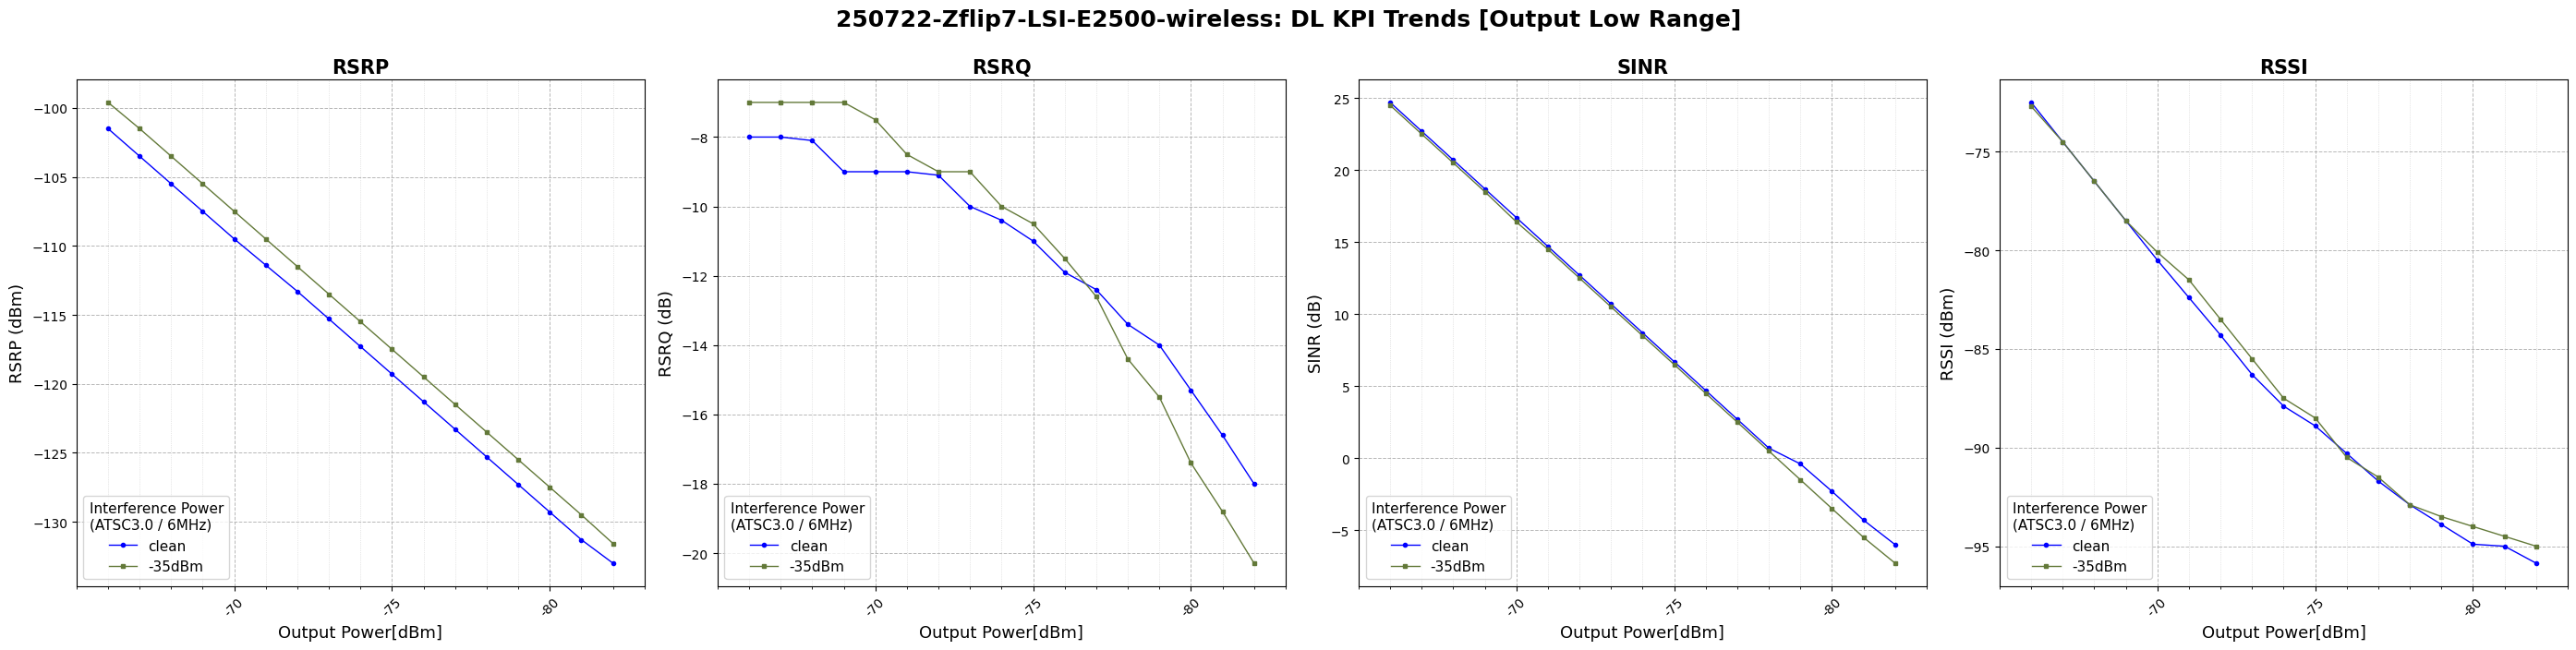

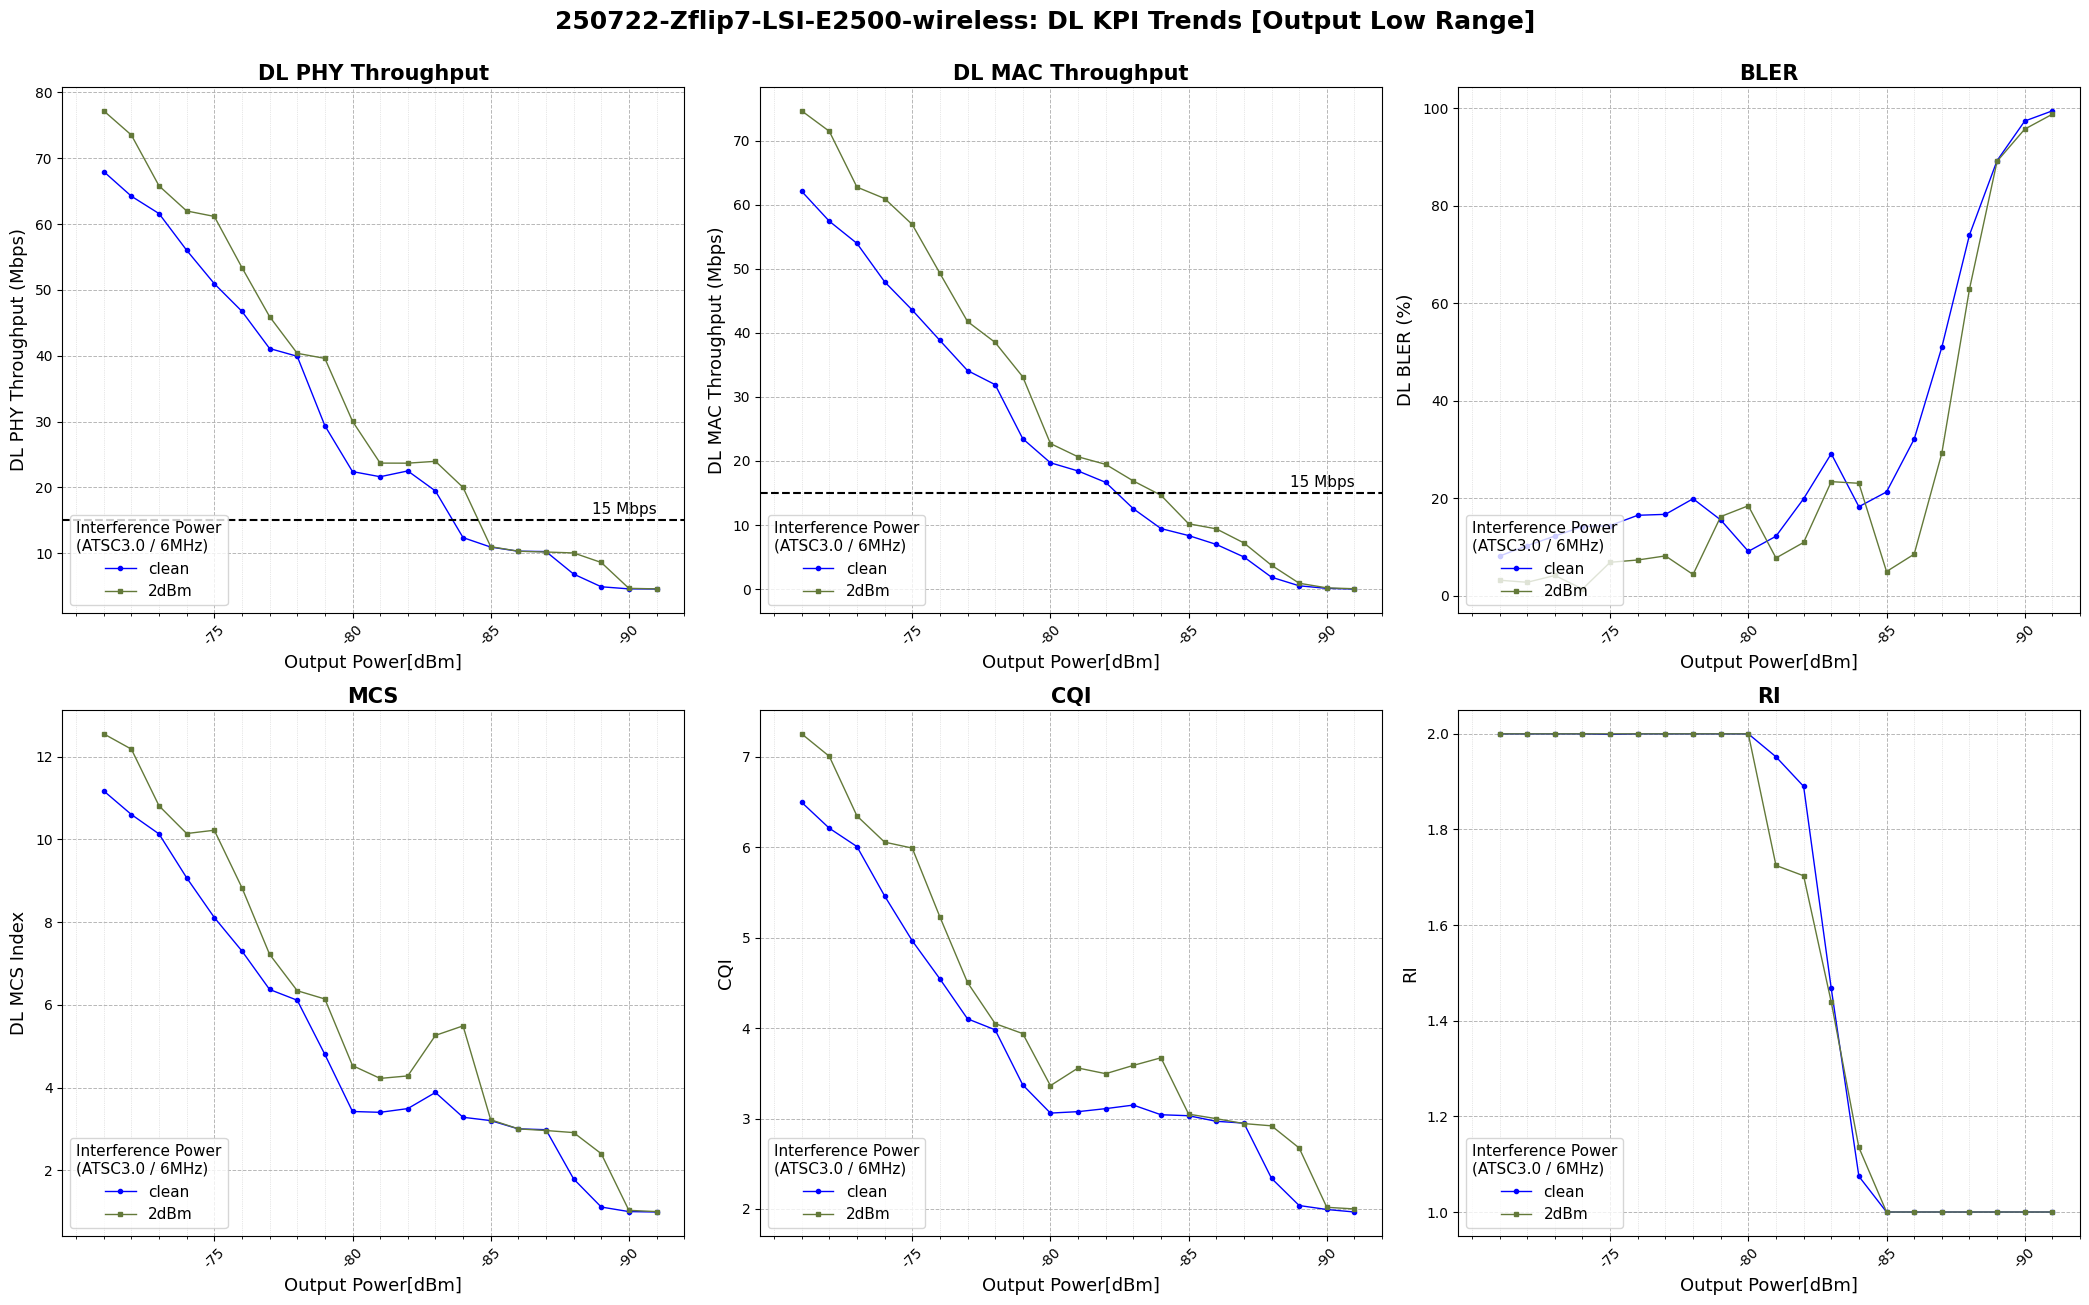

In [12]:
plot_kpis("250722-Zflip7-LSI-E2500-wireless", out_start=-50, interval=10, if_name="ATSC3.0 / 6MHz", file_format='xlsx', rsrp_class='low')
plot_kpis("250722-Zflip7-LSI-E2500-wireless", out_start=-50, interval=10, if_name="ATSC3.0 / 6MHz", file_format='csv', rsrp_class='low')

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os

def plot_tput(test_dir, out_start, interval, if_name="ATSC3.0 / 6MHz", layer='PHY'):

    df_stacked = concat_kpi_from_csv(test_dir=test_dir, out_start=out_start, interval=interval)
    df = df_stacked.reset_index()
    
    unique_powers = df["UHD_Power"].unique().tolist()
    sorted_powers = sorted(
        unique_powers,
        key=lambda x: -999 if x == "clean" else (
            999 if x == "n26_10M" else int(x.replace("dBm", "")) if "dBm" in x and x.replace("dBm", "").lstrip("-").isdigit() else 0
        )
    )
    source_order = {power: idx + 1 for idx, power in enumerate(sorted_powers)}

    out_start = df["Out_Int"].max()
    out_end = df["Out_Int"].min()
    df_filter = df[(df["Out_Int"] <= out_start) & (df["Out_Int"] >= out_end)]

    start_tick = int(math.floor(out_start / 5.0)) * 5
    end_tick = int(math.ceil(out_end / 5.0)) * 5
    xtick_labels = list(range(start_tick, end_tick - 1, -5))

    if layer == 'PHY': 
        abs_df = df_filter.groupby(["Out_Int", "UHD_Power"])["DL_PHY_Tput[Mbps]"].mean().unstack()
    elif layer == 'MAC': 
        abs_df = df_filter.groupby(["Out_Int", "UHD_Power"])["DL_MAC_Tput[Mbps]"].mean().unstack()
    rel_df = abs_df.divide(abs_df["clean"], axis=0) * 100
    # display(rel_df.head(20))
    
    style_map = {}
    cmap = plt.get_cmap("tab20b")    
    base_sources = [s for s in source_order if s not in ['clean', 'n26_10M']]
    num_base = len(base_sources)
    base_colors = [cmap(i / 20) for i in np.linspace(4, 19, num=num_base, dtype=int)]
    base_markers = ['s', 'D', '^', 'v', '<', '>', '*', 'P', 'X', '.', ',', '1', '2', '3', '4']
    
    style_map['clean'] = {'color': 'blue', 'linestyle': '-', 'linewidth': 1, 'marker': 'o'}    
    if 'n26_10M' in source_order:
        style_map['n26_10M'] = {'color': 'gray', 'linestyle': ':', 'linewidth': 2, 'marker': None}
        
    for i, s in enumerate(base_sources):
        style_map[s] = {
            'color': base_colors[i % len(base_colors)],
            'linestyle': '-',
            'linewidth': 1,
            'marker': base_markers[i % len(base_markers)]
        }

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    ax1, ax2 = axs.flatten()
    
    # ➤ 1. 절대값 (Mbps)
    for i, source in enumerate(source_order):
        if source not in abs_df.columns:
            continue
        style = style_map[source]
        ax1.plot(
            abs_df.index,
            abs_df[source],
            marker=style['marker'],
            markersize=3,
            color=style['color'],
            label=source,
            linestyle=style['linestyle'],
            linewidth=style['linewidth'],
        )

    if layer == 'PHY': 
        ax1.set_title("DL PHY Throughput", fontsize=14, weight='bold')
    elif layer == 'MAC': 
        ax1.set_title("DL MAC Throughput", fontsize=14, weight='bold')
    ax1.set_xlabel("Output Power[dBm]", fontsize=12)
    ax1.set_ylabel("Throughput [Mbps]", fontsize=12)
    ax1.set_xticks(xtick_labels)
    ax1.set_xticklabels(xtick_labels, rotation=45)
    ax1.set_xlim(out_start + 1, out_end - 1)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(title=f"Interference\n({if_name})", loc="lower left", fontsize=9, title_fontsize=9)

    # ➤ 2. 상대값 (%)
    for i, source in enumerate(source_order):
        if source == "clean" or source not in rel_df.columns:
            continue
        style = style_map[source]
        ax2.plot(
            rel_df.index,
            rel_df[source],
            marker=style['marker'],
            markersize=3,
            color=style['color'],
            label=source,
            linestyle=style['linestyle'],
            linewidth=style['linewidth'],
        )
    ax2.axhline(100, color='black', linestyle='--', linewidth=1)

    if layer == 'PHY': 
        ax2.set_title("DL PHY Relative Tput (% of Clean)", fontsize=14, weight='bold')
    elif layer == 'MAC': 
        ax2.set_title("DL MAC Relative Tput (% of Clean)", fontsize=14, weight='bold')
    ax2.set_xlabel("Output Power[dBm]", fontsize=12)
    ax2.set_ylabel("Relative Throughput [%]", fontsize=12)
    ax2.set_xticks(xtick_labels)
    ax2.set_xticklabels(xtick_labels, rotation=45)
    ax2.set_xlim(out_start + 1, out_end - 1)
    ax2.set_ylim(0, 120)
    ax2.set_yticks(np.arange(0, 121, 10))
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(title=f"Interference\n({if_name})", loc="lower left", fontsize=9, title_fontsize=9)

    # fig.suptitle(f"{test_dir} (UHD Power {'over' if if_up else 'under'} {if_power} dBm)", fontsize=15, weight='bold', y=0.96)
    fig.suptitle(f"{test_dir} DL {layer} Throughput", fontsize=15, weight='bold', y=0.96)

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    output_path = os.path.join(test_dir, f"{test_dir}_DL_{layer}_Tput.png")
    plt.savefig(output_path, dpi=300)
    plt.show()

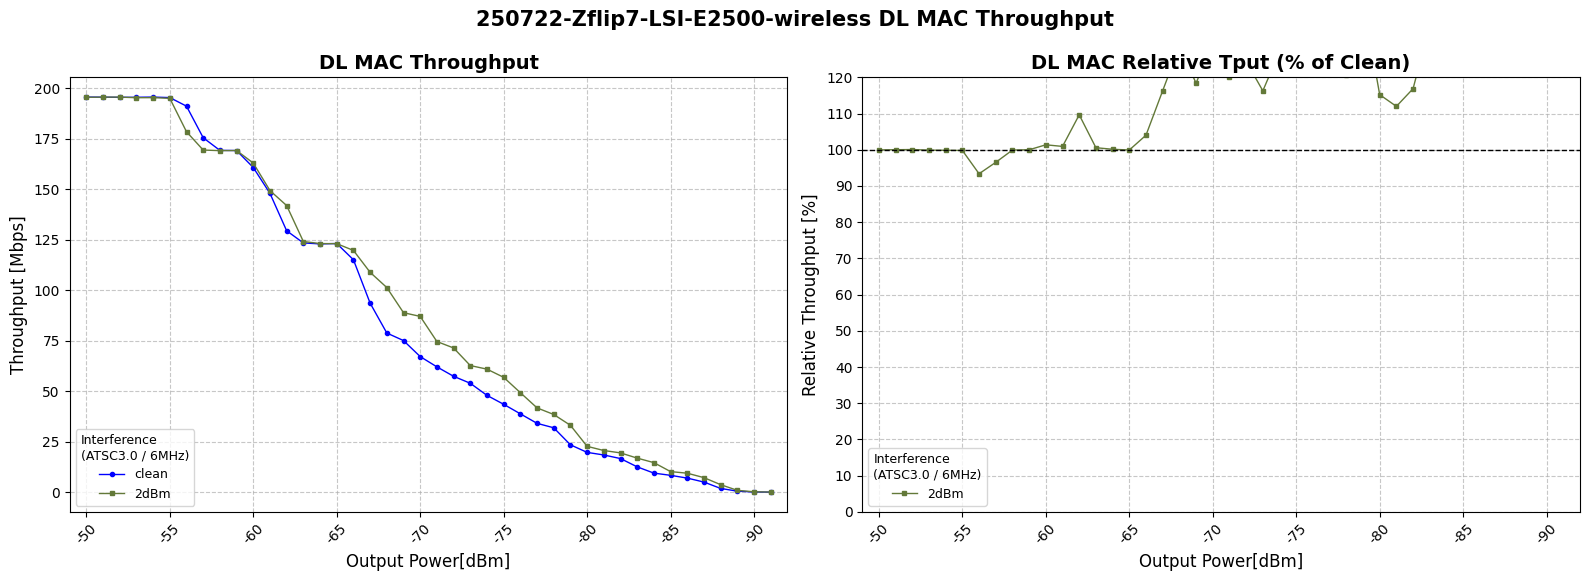

In [14]:
plot_tput(test_dir="250722-Zflip7-LSI-E2500-wireless", out_start=-50, interval=10, if_name="ATSC3.0 / 6MHz", layer='MAC')

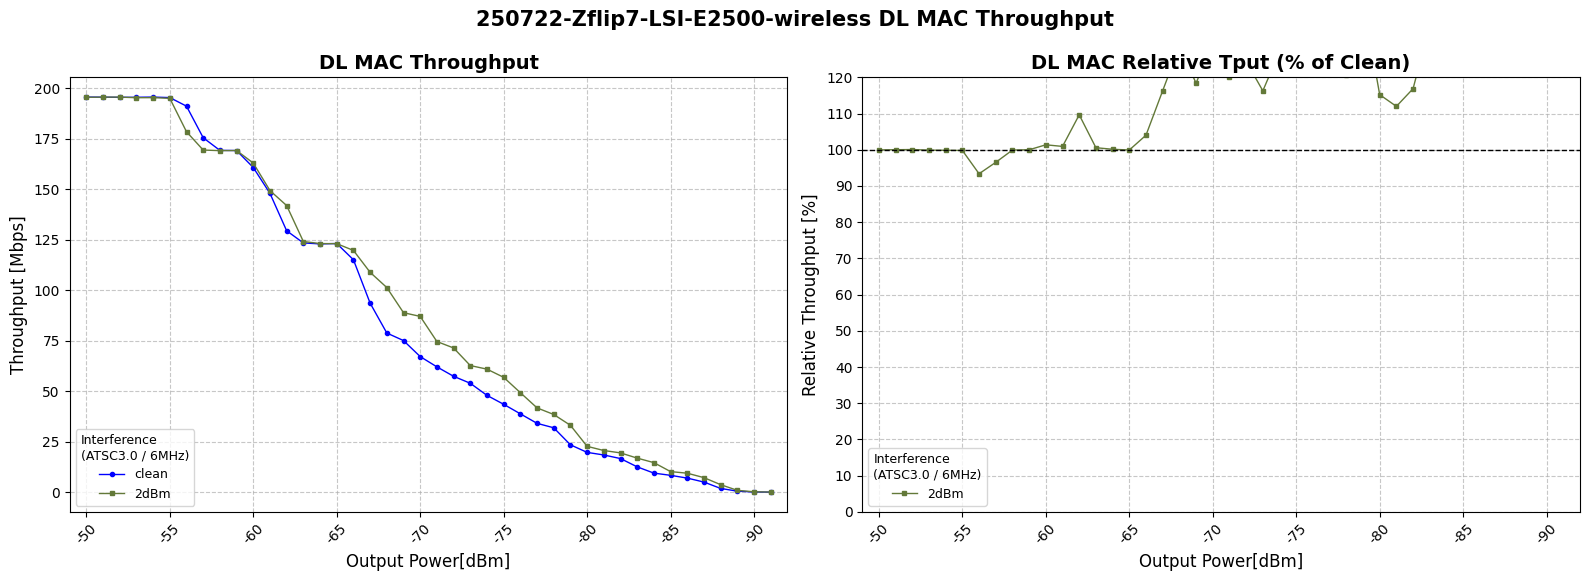

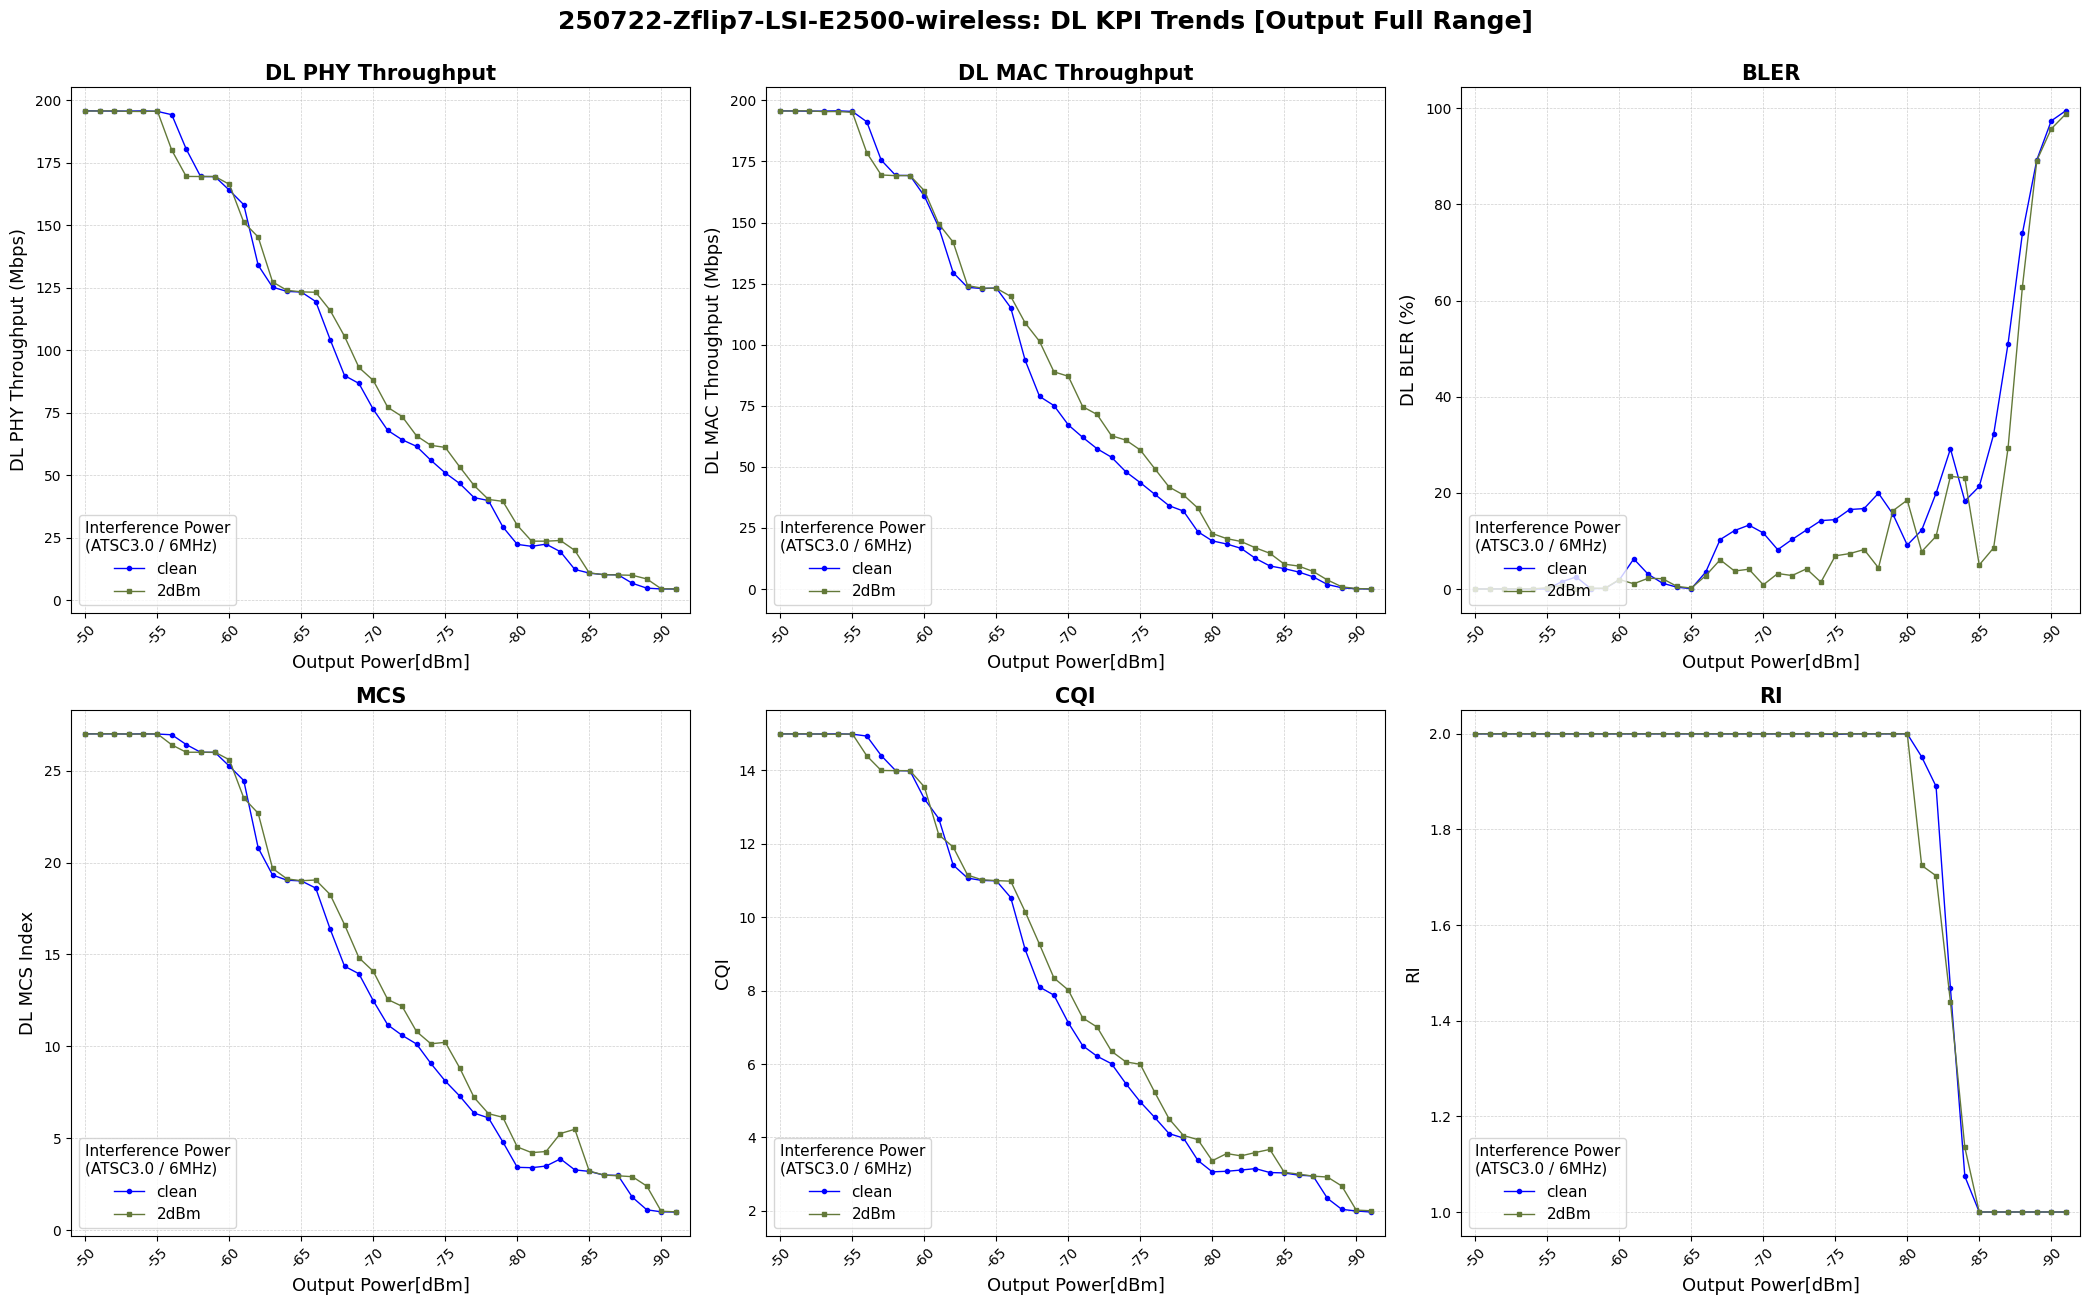

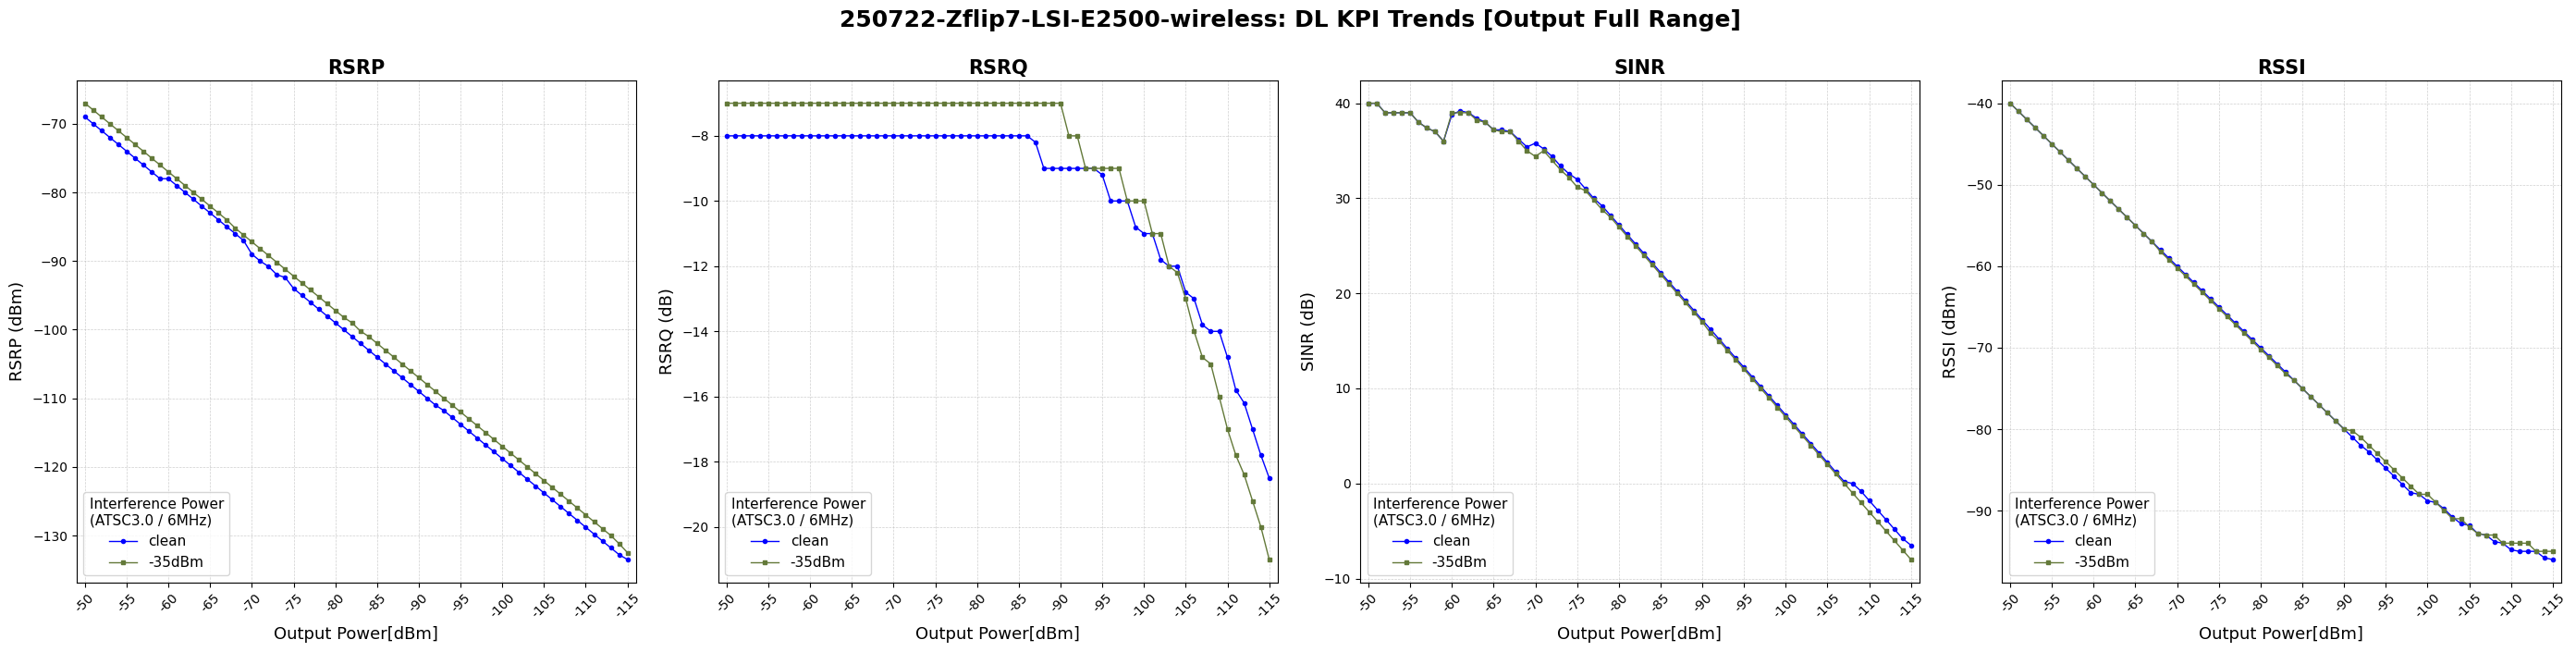

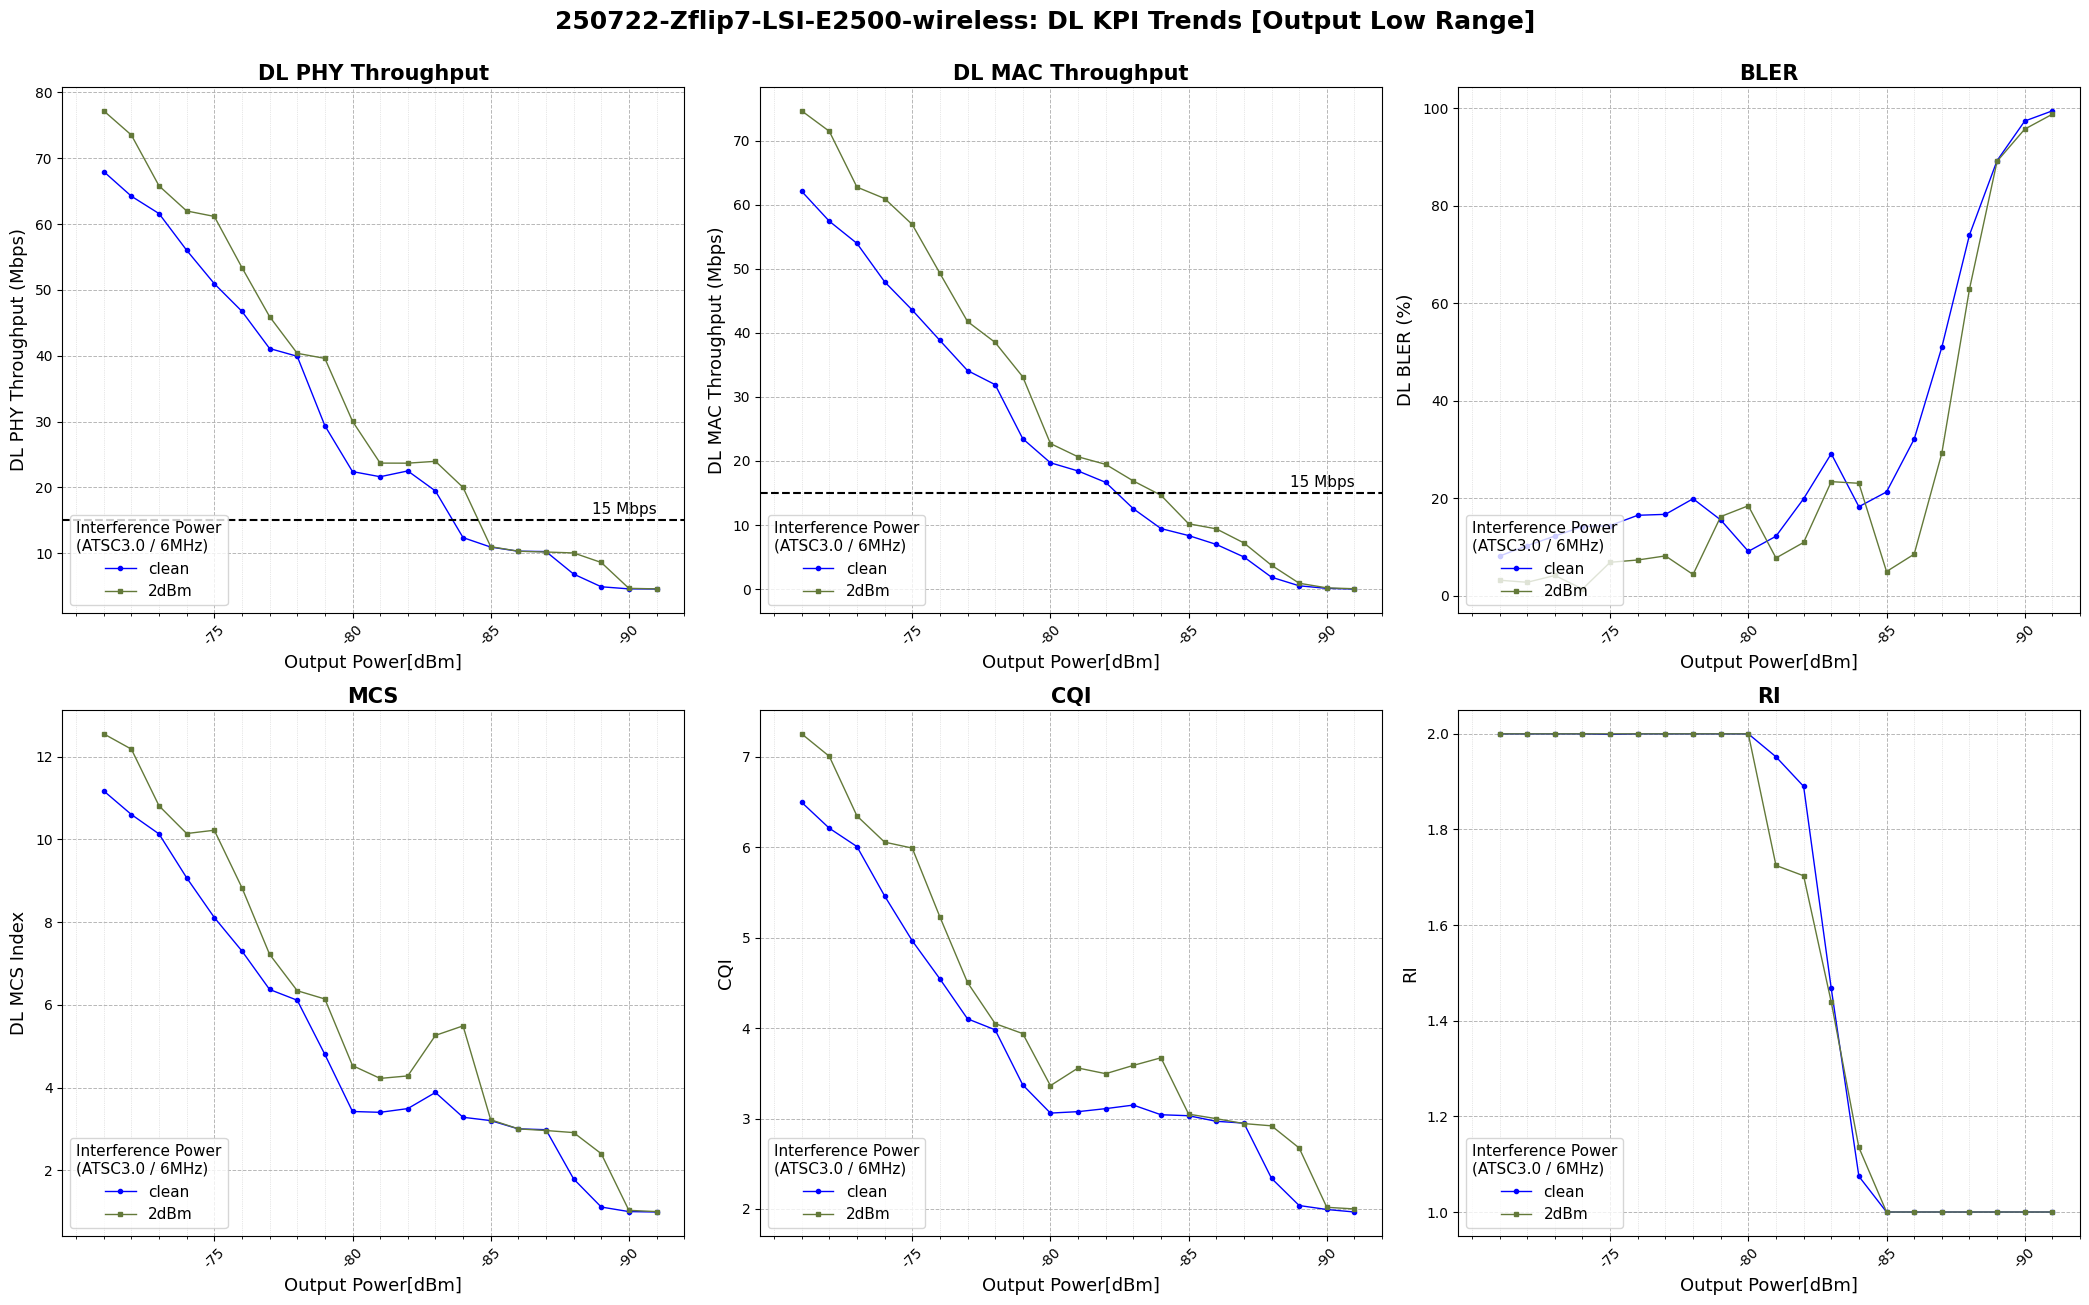

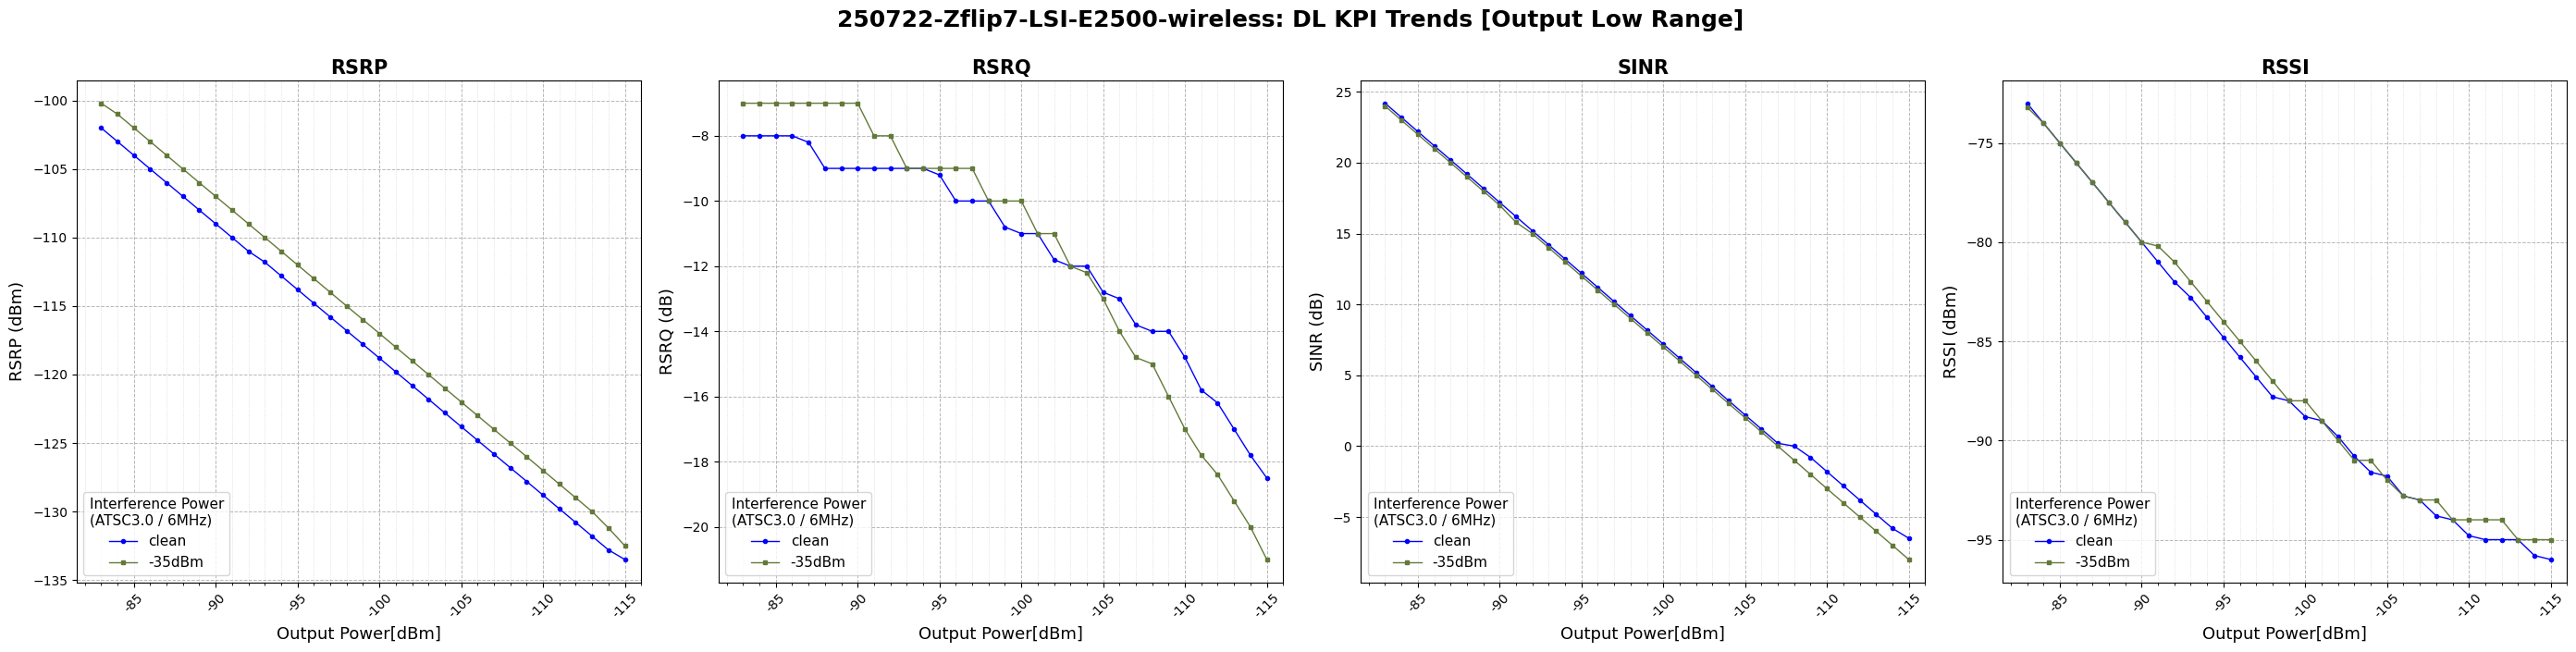

In [15]:
test_cases = [
    "250722-Zflip7-LSI-E2500-wireless",
]
out_start = -50
interfere = "ATSC3.0 / 6MHz"

for test_case in test_cases:
    plot_tput(test_dir=test_case, out_start=out_start, interval=10, if_name=interfere, layer='MAC')
    plot_kpis(test_dir=test_case, out_start=out_start, interval=10, if_name=interfere, file_format='csv', rsrp_class='all')
    plot_kpis(test_dir=test_case, out_start=out_start, interval=5, if_name=interfere, file_format='xlsx', rsrp_class='all')
    plot_kpis(test_dir=test_case, out_start=out_start, interval=10, if_name=interfere, file_format='csv', rsrp_class='low')
    plot_kpis(test_dir=test_case, out_start=out_start, interval=5, if_name=interfere, file_format='xlsx', rsrp_class='low')